In [32]:
#importing all necessary packages
#I'll be working on tensorflow framework

import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import BatchNormalization,Rescaling,Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam, SGD
import cv2
import imghdr
from tensorflow.keras.models import load_model

In [3]:
#i'll keep the resolution to be 240x240
#and batch size will be 32

base_dir = 'vlg-dataset/train/'
img_size = 240
batch = 32

In [6]:
#I'll keep 20% of the images for validation dataset...
#And used seed123 so that same shuffled images are alotted to same batch verytime the code is run.....(tried to keep consistency)
#I also added some data set of unseen classes...therefore the code detected 50 classes(40 seen + 10 unseen)

train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                   subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                     validation_split=0.2,
                                                  subset = 'validation',
                                                      batch_size=batch,
                                                     image_size=(img_size,img_size))


Found 10877 files belonging to 50 classes.
Using 8702 files for training.
Found 10877 files belonging to 50 classes.
Using 2175 files for validation.


In [7]:
# created a list of all the classes of annimals
animal_names = train_ds.class_names
animal_names

['antelope',
 'bat',
 'beaver',
 'blue+whale',
 'bobcat',
 'buffalo',
 'chihuahua',
 'chimpanzee',
 'collie',
 'cow',
 'dalmatian',
 'deer',
 'dolphin',
 'elephant',
 'fox',
 'german+shepherd',
 'giant+panda',
 'giraffe',
 'gorilla',
 'grizzly+bear',
 'hamster',
 'hippopotamus',
 'horse',
 'humpback+whale',
 'killer+whale',
 'leopard',
 'lion',
 'mole',
 'moose',
 'mouse',
 'otter',
 'ox',
 'persian+cat',
 'pig',
 'polar+bear',
 'rabbit',
 'raccoon',
 'rat',
 'rhinoceros',
 'seal',
 'sheep',
 'siamese+cat',
 'skunk',
 'spider+monkey',
 'squirrel',
 'tiger',
 'walrus',
 'weasel',
 'wolf',
 'zebra']

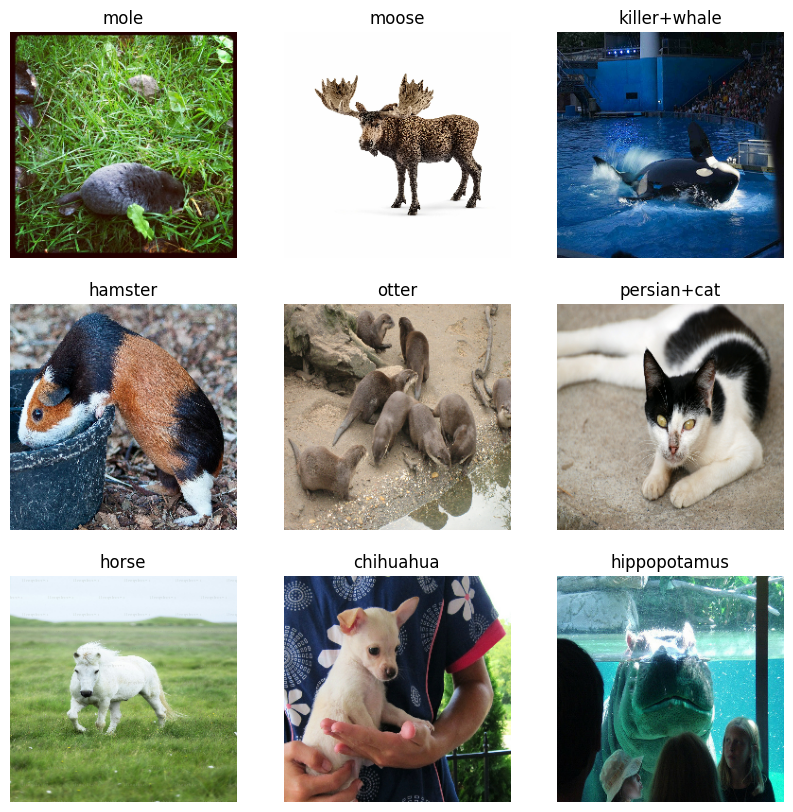

In [18]:
#checking if the dataset is made properly...also the batches

i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    #we will get images in form of tensors
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))#this converts i th img from tensor to numpy and then to uint8(standard to display values of pixel from the numpy format)
        plt.title(animal_names[labels[i]])
        plt.axis('off')

In [11]:
# I'm using a sequential model
model = Sequential()
#adding a layer which does the data augmentation on the train data
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomContrast(0.2),
])
#I'll be using a pretrained model which is EfficientNetV2L.....
#As it not only provides well extablished cnn architecture but also it make changes in the config of convolutional layers withe the training process

pretrained_model = tf.keras.applications.EfficientNetV2L(
    include_top=False,
    input_shape=(240, 240, 3),
    pooling='avg',
    weights='imagenet'
)
#Here i tested with unfreezing the last layers of the model...so the layers train the weights according to the our dataset

#for layer in pretrained_model.layers:
        #layer.trainable=False
for layer in pretrained_model.layers[:-80]:  # Freeze all but last 80 layers
    layer.trainable = False
 
model.add(data_augmentation)
model.add(pretrained_model)
model.add(Dense(256, activation='relu', 
                kernel_regularizer=tf.keras.regularizers.l2(0.01)
               ))#applied regularisation...to avoid overfitting...with lambda=0.01
# also applied droput layer to avoid overfitting...
model.add(Dropout(0.5))
model.add(Dense(50))#as the final layer will return 50 classes (I have used softmax only...just to avoid calculation errors I used "from_logits=True" in loss function)



In [29]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (Functiona  (None, 1280)             117746848 
 l)                                                              
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 50)                12850     
                                                                 
Total params: 118,087,634
Trainable params: 32,158,546
Non-trainable params: 85,929,088
_________________________________________________________________


In [13]:
model.compile(
    optimizer=  tf.keras.optimizers.SGD(
    learning_rate=1e-3,  # Start with 0.001
    momentum=0.9,        # Momentum for acceleration
    nesterov=True        # Nesterov momentum for better convergence
),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)



In [14]:
#used 20 epochs....as it provides good train and val accuracy...and not overfitting too much
epochs_size = 20
history = model.fit(train_ds,
                    validation_data=val_ds  ,
                    epochs=epochs_size)

Epoch 1/20
272/272 [==============================] - 357s 1s/step - loss: 7.3345 - accuracy: 0.3297 - val_loss: 5.5951 - val_accuracy: 0.7582
Epoch 2/20
272/272 [==============================] - 284s 1s/step - loss: 5.2293 - accuracy: 0.7029 - val_loss: 4.1801 - val_accuracy: 0.8506
Epoch 3/20
272/272 [==============================] - 284s 1s/step - loss: 4.3236 - accuracy: 0.7717 - val_loss: 3.6200 - val_accuracy: 0.8814
Epoch 4/20
272/272 [==============================] - 281s 1s/step - loss: 3.7710 - accuracy: 0.8141 - val_loss: 3.2095 - val_accuracy: 0.9011
Epoch 5/20
272/272 [==============================] - 291s 1s/step - loss: 3.3910 - accuracy: 0.8305 - val_loss: 2.8853 - val_accuracy: 0.9113
Epoch 6/20
272/272 [==============================] - 286s 1s/step - loss: 3.0570 - accuracy: 0.8490 - val_loss: 2.6131 - val_accuracy: 0.9149
Epoch 7/20
272/272 [==============================] - 283s 1s/step - loss: 2.7556 - accuracy: 0.8582 - val_loss: 2.3680 - val_accuracy: 0.9200

Text(0.5, 1.0, 'Loss')

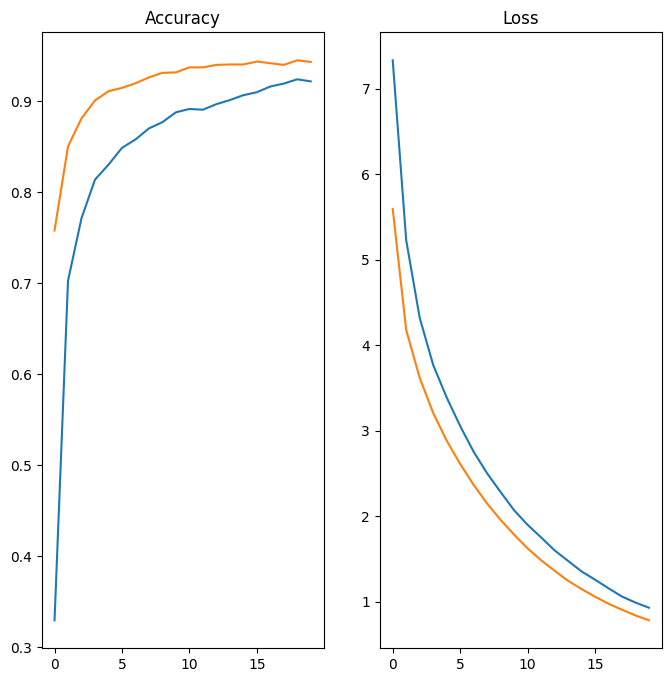

In [22]:
epochs_range = range(epochs_size)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,history.history['accuracy'],label = 'Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'],label = 'Validation Accuracy')
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range,history.history['loss'],label = 'Training Loss')
plt.plot(epochs_range, history.history['val_loss'],label = 'Validation Loss')
plt.title('Loss')

In [34]:
model.save(os.path.join('models','final_model.h5'))#to save the final model

In [44]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(240,240))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)#to make the input array equivalent to take 4 inputs...
    # As Neural networks in TensorFlow expect inputs in batches  (batch_size, height, width, channels).

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome =  animal_names[np.argmax(result)] 
    return outcome

In [46]:
classify_images('vlg-dataset/test/00071.jpg')

1/1 [==============================] - 0s 139ms/step


'sheep'

In [28]:
import pandas as pd

In [48]:
import csv
import os


# Directory containing the images
image_dir = "vlg-dataset/test/"

# Path to save the CSV file
csv_file = "pred.csv"

# Create the CSV file
with open(csv_file, mode="w", newline="") as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(["image_id", "class"])
    
    # Process each image in the directory
    for idx, image_name in enumerate(os.listdir(image_dir), start=1):
        if image_name.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):  # Check for image file extensions
            image_path = os.path.join(image_dir, image_name)
            class_label = classify_images(image_path)
            # Write the image ID and class to the CSV
            writer.writerow([image_name, class_label])

print(f"CSV file '{csv_file}' created successfully.")


1/1 [==============================] - 0s 111ms/step
CSV file 'pred.csv' created successfully.


In [48]:
# making predictions for special package
import csv
import os


# Directory containing the images
image_dir = "Special-Package/final_examples/"

# Path to save the CSV file
csv_file = "pred(special_package).csv"

# Create the CSV file
with open(csv_file, mode="w", newline="") as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(["image_id", "class"])
    
    # Process each image in the directory
    for idx, image_name in enumerate(os.listdir(image_dir), start=1):
        if image_name.lower().endswith((".png", ".jpg", ".jpeg", ".bmp")):  # Check for image file extensions
            image_path = os.path.join(image_dir, image_name)
            class_label = classify_images(image_path)
            # Write the image ID and class to the CSV
            writer.writerow([image_name, class_label])

print(f"CSV file '{csv_file}' created successfully.")

1/1 [==============================] - 0s 84ms/step
CSV file 'pred(special_package).csv' created successfully.
